##### In addition to drop 'doctor_segment_C_calls', 'doctor_segment_A1_calls', 'doctor_segment_A2_calls', 'doctor_segment_B2_calls', 'doctor_segment_C3_calls'
##### we will drop 'account_id', 'date'

In [1]:
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
!pip install xgboost

     |████████████████████████████████| 127.6 MB 6.7 kB/s  eta 0:00:01


In [1]:
#Import all libraries that will be used
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.formula.api as sm
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import xgboost
%matplotlib inline

### 1. Loading Data from BigQuery

In [2]:
# As original dataset is not huge, we use all records
from google.cloud import bigquery
query = """
SELECT
  date,
  year,
  month, 
  account_id,
  company_patients as number_of_patients,
  competitor_patients,
  specialist_calls_1,
  specialist_calls_2,
  specialist_calls_3,
  specialist_calls_4,
  Brand_awareness_calls,
  doctor_segment_1_calls,
  doctor_segment_2_calls,
  doctor_segment_3_calls,
  doctor_segment_A_calls,
  doctor_segment_B_calls,
  doctor_segment_C_calls,
  doctor_segment_A1_calls,
  doctor_segment_A2_calls,
  doctor_segment_A3_calls,
  doctor_segment_B1_calls,
  doctor_segment_B2_calls,
  doctor_segment_B3_calls,
  doctor_segment_C1_calls,
  doctor_segment_C2_calls,
  doctor_segment_C3_calls,
  Remote_channel_calls,
  F2F_CLM_calls,
  F2F_NCLM_calls,
FROM
  marine-atrium-255618.Interview_Test.dataset1
"""

data = bigquery.Client().query(query).to_dataframe()
data.head()


,date,year,month,account_id,number_of_patients,competitor_patients,specialist_calls_1,specialist_calls_2,specialist_calls_3,specialist_calls_4,...,doctor_segment_A3_calls,doctor_segment_B1_calls,doctor_segment_B2_calls,doctor_segment_B3_calls,doctor_segment_C1_calls,doctor_segment_C2_calls,doctor_segment_C3_calls,Remote_channel_calls,F2F_CLM_calls,F2F_NCLM_calls
0,2018-01-01,2018,1,605621464020,739,1350,30,46,31,4,...,3,14,7,4,11,2,7,4,4,100
1,2018-01-01,2018,1,605621560142,508,1135,25,37,50,5,...,3,8,9,2,3,2,5,1,18,86
2,2018-01-01,2018,1,605621300438,678,1509,48,38,45,4,...,1,4,13,1,12,3,7,1,3,121
3,2018-01-01,2018,1,605621334336,404,866,14,15,18,2,...,1,2,5,1,1,2,3,1,3,40
4,2018-01-01,2018,1,605621302304,533,1120,37,30,25,3,...,1,2,12,1,1,2,7,1,3,81


### 2. Data Exploration

In [3]:
#check the information of all the features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   date                     2900 non-null   object
 1   year                     2900 non-null   int64 
 2   month                    2900 non-null   int64 
 3   account_id               2900 non-null   int64 
 4   number_of_patients       2900 non-null   int64 
 5   competitor_patients      2900 non-null   int64 
 6   specialist_calls_1       2900 non-null   int64 
 7   specialist_calls_2       2900 non-null   int64 
 8   specialist_calls_3       2900 non-null   int64 
 9   specialist_calls_4       2900 non-null   int64 
 10  Brand_awareness_calls    2900 non-null   int64 
 11  doctor_segment_1_calls   2900 non-null   int64 
 12  doctor_segment_2_calls   2900 non-null   int64 
 13  doctor_segment_3_calls   2900 non-null   int64 
 14  doctor_segment_A_calls   2900 non-null  

In [5]:
#check the statistics of all the featurs such as mean, median(50th perecentile), std etc.
data.describe()

,year,month,account_id,number_of_patients,competitor_patients,specialist_calls_1,specialist_calls_2,specialist_calls_3,specialist_calls_4,Brand_awareness_calls,...,doctor_segment_A3_calls,doctor_segment_B1_calls,doctor_segment_B2_calls,doctor_segment_B3_calls,doctor_segment_C1_calls,doctor_segment_C2_calls,doctor_segment_C3_calls,Remote_channel_calls,F2F_CLM_calls,F2F_NCLM_calls
count,2900.000000,2900.000000,2.900000e+03,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000,...,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000
mean,2018.758621,5.896552,6.056218e+11,514.425517,1283.565172,26.325517,30.415517,35.522414,4.486897,33.521034,...,1.765172,3.873448,10.102069,2.091724,2.235517,4.454828,6.476552,2.484828,6.136897,73.969310
std,0.726722,3.458170,2.886826e+06,121.940882,295.390867,15.848767,15.518589,18.026594,3.060080,18.907700,...,1.904324,2.909617,6.472053,2.429382,2.453861,3.873610,6.326775,4.182139,5.945326,29.871995
min,2018.000000,1.000000,6.056211e+11,257.000000,642.000000,13.000000,15.000000,18.000000,2.000000,17.000000,...,1.000000,2.000000,5.000000,1.000000,1.000000,2.000000,3.000000,1.000000,3.000000,37.000000
25%,2018.000000,3.000000,6.056213e+11,431.000000,1090.000000,14.000000,19.000000,22.000000,2.000000,19.000000,...,1.000000,2.000000,5.000000,1.000000,1.000000,2.000000,3.000000,1.000000,3.000000,50.000000
50%,2019.000000,5.000000,6.056214e+11,496.500000,1238.000000,21.000000,26.000000,30.000000,4.000000,27.000000,...,1.000000,2.000000,8.000000,1.000000,1.000000,3.000000,4.000000,1.000000,3.000000,69.000000
75%,2019.000000,9.000000,6.056214e+11,590.000000,1432.250000,33.000000,37.000000,43.000000,6.000000,42.000000,...,1.000000,5.000000,12.000000,2.000000,2.000000,5.000000,7.000000,2.000000,7.000000,91.000000
max,2020.000000,12.000000,6.056420e+11,869.000000,2801.000000,133.000000,152.000000,135.000000,32.000000,178.000000,...,18.000000,27.000000,46.000000,30.000000,27.000000,32.000000,63.000000,46.000000,60.000000,196.000000


In [6]:
#check the distribution across different years
data['year'].value_counts()

2019    1200
2018    1200
2020     500
Name: year, dtype: int64

In [7]:
#check distribution across different months
data['month'].value_counts()

5     300
3     300
1     300
4     300
2     300
11    200
9     200
7     200
12    200
10    200
8     200
6     200
Name: month, dtype: int64

In [4]:
#create a new feature(Month_year) from the date 
data['month_year'] = pd.to_datetime(data['date']).dt.to_period('M')

In [5]:
#check the distribution across the month_year features
data['month_year'].value_counts()

2020-04    100
2020-03    100
2018-03    100
2018-05    100
2018-07    100
2018-09    100
2018-11    100
2019-01    100
2019-03    100
2019-05    100
2019-07    100
2019-09    100
2019-11    100
2020-01    100
2020-05    100
2020-02    100
2018-02    100
2018-04    100
2018-06    100
2018-08    100
2018-10    100
2018-12    100
2019-02    100
2019-04    100
2019-06    100
2019-08    100
2019-10    100
2019-12    100
2018-01    100
Freq: M, Name: month_year, dtype: int64

In [10]:
#set the month_year as the index of the dataframe to ease time series analysis
data.set_index('month_year', inplace=True)

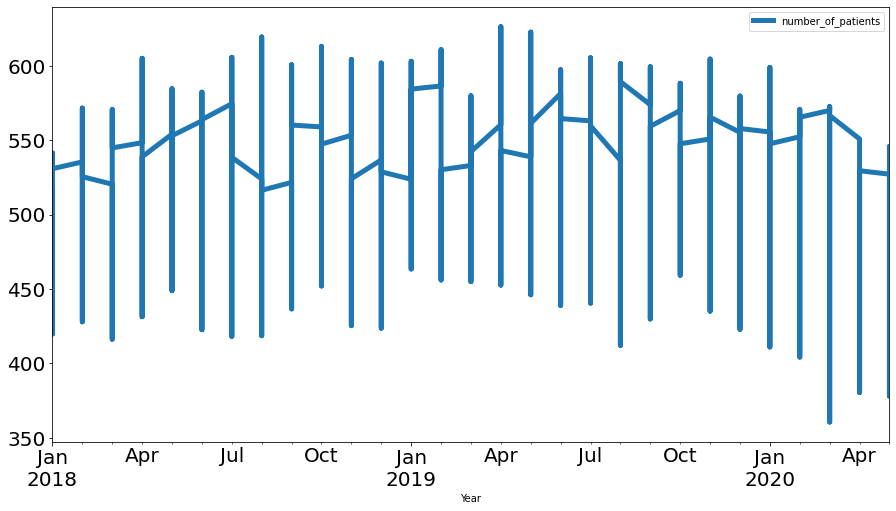

In [11]:
#Checking for Trend- unfortunately there is no enough month year points to establish a clear pattern
d = data[['number_of_patients']]
d.rolling(12).mean().plot(figsize=(15,8), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=10);

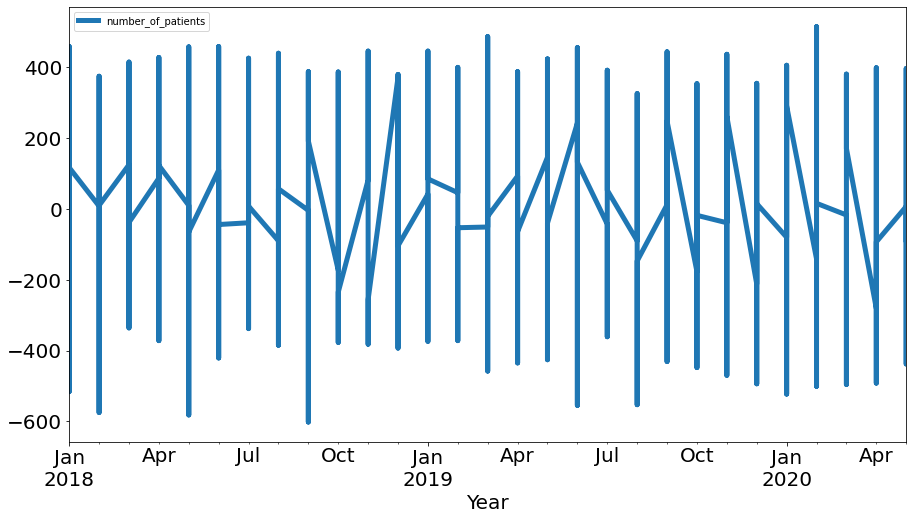

In [12]:
#Seasonality
d.diff().plot(figsize=(15,8), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [13]:
#create a tabular correlation heatmap, to check for correlation among features
cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

In [14]:
# calculate the correlation matrix
corr = data.corr()

,year,month,account_id,number_of_patients,competitor_patients,specialist_calls_1,specialist_calls_2,specialist_calls_3,specialist_calls_4,Brand_awareness_calls,doctor_segment_1_calls,doctor_segment_2_calls,doctor_segment_3_calls,doctor_segment_A_calls,doctor_segment_B_calls,doctor_segment_C_calls,doctor_segment_A1_calls,doctor_segment_A2_calls,doctor_segment_A3_calls,doctor_segment_B1_calls,doctor_segment_B2_calls,doctor_segment_B3_calls,doctor_segment_C1_calls,doctor_segment_C2_calls,doctor_segment_C3_calls,Remote_channel_calls,F2F_CLM_calls,F2F_NCLM_calls
year,1.00,-0.30,-0.00,-0.06,0.25,-0.42,-0.24,-0.33,0.01,-0.39,-0.25,-0.29,-0.29,-0.26,-0.34,-0.32,-0.19,-0.21,-0.18,-0.25,-0.24,-0.21,-0.17,-0.21,-0.24,0.41,-0.12,-0.48
month,-0.30,1.00,-0.00,0.04,0.01,-0.09,-0.03,-0.01,-0.06,-0.03,-0.05,-0.06,-0.01,-0.04,-0.06,-0.06,-0.02,-0.04,0.00,-0.06,-0.05,0.02,-0.04,-0.05,-0.03,-0.14,-0.13,-0.03
account_id,-0.00,-0.00,1.00,-0.09,-0.05,0.04,0.11,0.02,0.09,0.02,-0.01,0.00,-0.03,-0.02,-0.00,-0.00,-0.04,-0.05,0.15,0.07,-0.02,-0.04,-0.06,0.14,-0.06,-0.02,-0.03,0.02
number_of_patients,-0.06,0.04,-0.09,1.00,0.53,0.21,0.27,0.38,0.20,0.21,0.23,0.30,0.26,0.40,0.18,0.27,0.26,0.36,0.20,0.08,0.16,0.12,0.17,0.13,0.22,0.04,0.15,0.40
competitor_patients,0.25,0.01,-0.05,0.53,1.00,0.02,0.08,0.26,0.14,0.11,0.04,0.16,0.26,0.25,0.06,0.17,0.10,0.23,0.25,-0.07,0.03,0.20,0.03,0.06,0.18,0.17,0.08,0.21
specialist_calls_1,-0.42,-0.09,0.04,0.21,0.02,1.00,0.30,0.42,0.07,0.53,0.43,0.57,0.42,0.44,0.60,0.57,0.34,0.36,0.17,0.38,0.51,0.24,0.28,0.45,0.40,-0.14,0.20,0.66
specialist_calls_2,-0.24,-0.03,0.11,0.27,0.08,0.30,1.00,0.36,0.12,0.46,0.36,0.44,0.21,0.49,0.34,0.29,0.33,0.47,0.12,0.23,0.26,0.17,0.26,0.21,0.17,-0.11,0.25,0.57
specialist_calls_3,-0.33,-0.01,0.02,0.38,0.26,0.42,0.36,1.00,0.06,0.44,0.39,0.72,0.62,0.72,0.60,0.63,0.41,0.68,0.40,0.22,0.52,0.39,0.24,0.39,0.53,-0.16,0.23,0.79
specialist_calls_4,0.01,-0.06,0.09,0.20,0.14,0.07,0.12,0.06,1.00,0.07,0.08,0.06,0.04,0.11,0.03,0.05,0.07,0.08,0.09,0.05,-0.02,0.09,0.08,0.08,-0.01,-0.04,0.10,0.19
Brand_awareness_calls,-0.39,-0.03,0.02,0.21,0.11,0.53,0.46,0.44,0.07,1.00,0.38,0.45,0.42,0.44,0.45,0.50,0.31,0.37,0.23,0.32,0.33,0.27,0.27,0.34,0.37,-0.16,0.39,0.69


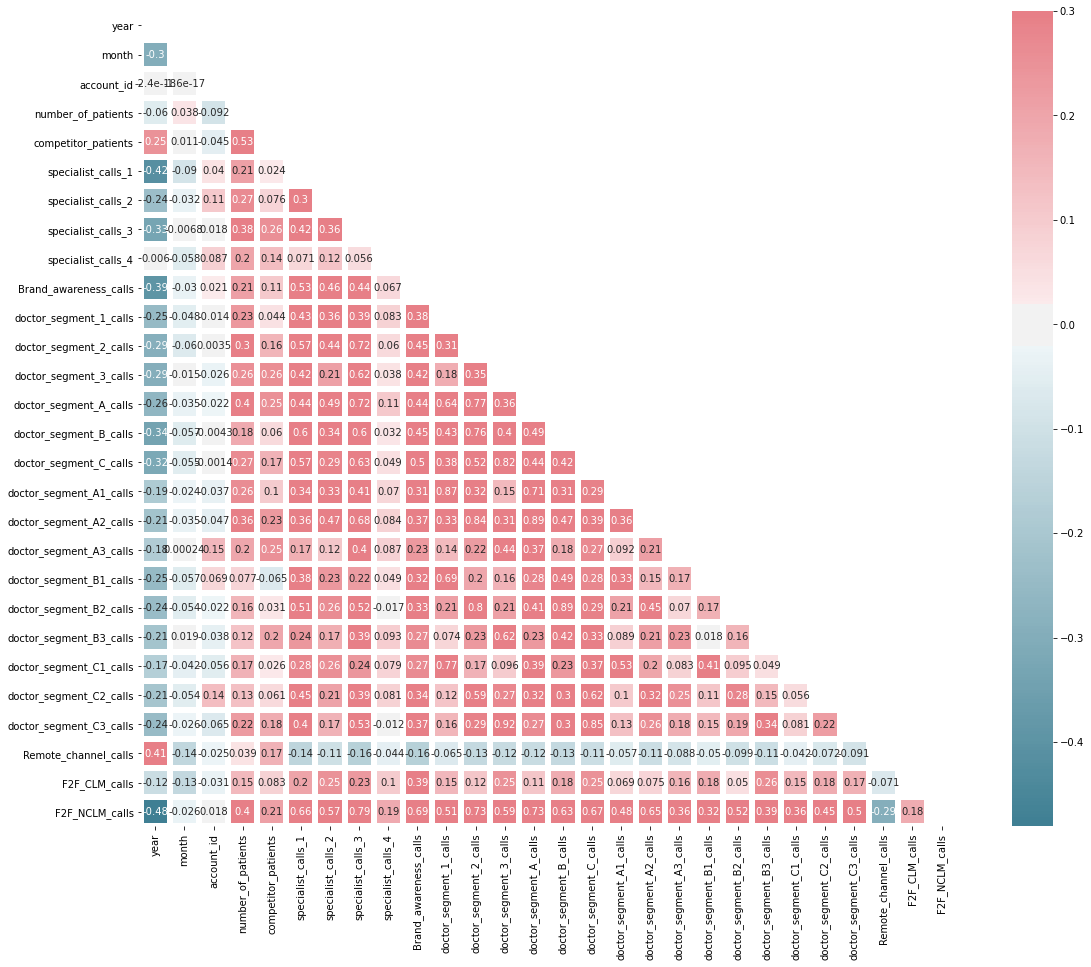

In [16]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=5, annot=True)


corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to Magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

#### The features that are most correlated to the dependent variable are: **competitor_patients**, **doctor_segment_A_calls** and **F2F_NCLM_calls**.


In [17]:
def correlation(data, threshold):
    dataset=data
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    print(dataset)

#correlation(data, 0.8)

#### We will remove highly correlated features to stop the effect of multi-collinearity

In [18]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

#### Correlation of 0.8 or higher
doctor_segment_C_calls correlated with doctor_segment_3_calls

doctor_segment_C3_calls correlated with doctor_segment_3_calls and doctor_segment_C_calls

doctor_segment_A1_calls correlated with doctor_segment_1_calls

doctor_segment_A2_calls correlated with doctor_segment_2_calls and doctor_segment_A_calls

doctor_segment_B2_calls correlated with doctor_segment_2_calls and doctor_segment_B_calls



In [19]:
#Features to be dropped
print(to_drop)

['doctor_segment_C_calls', 'doctor_segment_A1_calls', 'doctor_segment_A2_calls', 'doctor_segment_B2_calls', 'doctor_segment_C3_calls']


#### 'doctor_segment_C_calls', 'doctor_segment_A1_calls', 'doctor_segment_A2_calls', 'doctor_segment_B2_calls', 'doctor_segment_C3_calls' are have a correlation of greater than 0.8 with other features.

In [6]:
data_new = data.drop(['doctor_segment_C_calls', 'doctor_segment_A1_calls', 'doctor_segment_A2_calls', 'doctor_segment_B2_calls', 'doctor_segment_C3_calls'], axis=1)

In [21]:
data_new.head()

,date,year,month,account_id,number_of_patients,competitor_patients,specialist_calls_1,specialist_calls_2,specialist_calls_3,specialist_calls_4,...,doctor_segment_A_calls,doctor_segment_B_calls,doctor_segment_A3_calls,doctor_segment_B1_calls,doctor_segment_B3_calls,doctor_segment_C1_calls,doctor_segment_C2_calls,Remote_channel_calls,F2F_CLM_calls,F2F_NCLM_calls
month_year,,,,,,,,,,,,,,,,,,,,,
2018-01,2018-01-01,2018,1,605621464020,739,1350,30,46,31,4,...,32,25,3,14,4,11,2,4,4,100
2018-01,2018-01-01,2018,1,605621560142,508,1135,25,37,50,5,...,39,19,3,8,2,3,2,1,18,86
2018-01,2018-01-01,2018,1,605621300438,678,1509,48,38,45,4,...,49,18,1,4,1,12,3,1,3,121
2018-01,2018-01-01,2018,1,605621334336,404,866,14,15,18,2,...,10,8,1,2,1,1,2,1,3,40
2018-01,2018-01-01,2018,1,605621302304,533,1120,37,30,25,3,...,21,15,1,2,1,1,2,1,3,81


#### 5 features were dropped automatically due to their high correlation with other features. Please refer to the correlation heatmap table to check features that are strongly correlated.

In [7]:
#drop the date and account_id columns.
data = data_new.drop(['account_id', 'date'], axis=1)


In [8]:
X = data.drop('number_of_patients', axis=1)

In [9]:
y = data['number_of_patients']

In [25]:
#Labels and features
labels = y
features = X

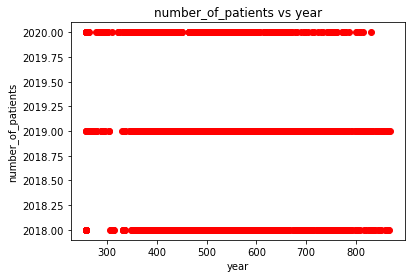

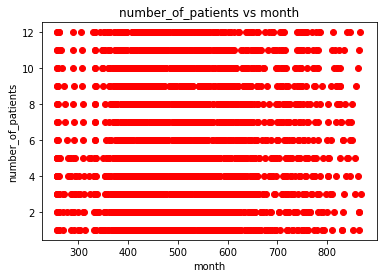

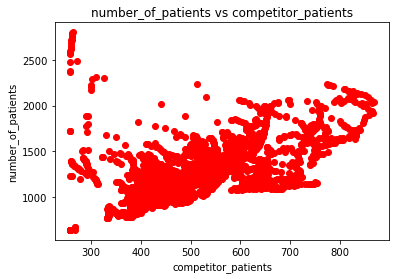

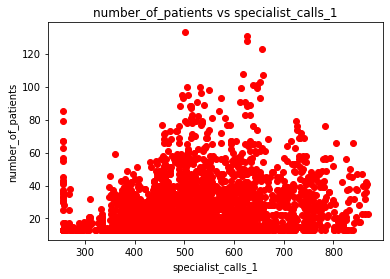

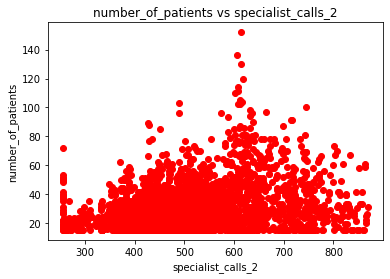

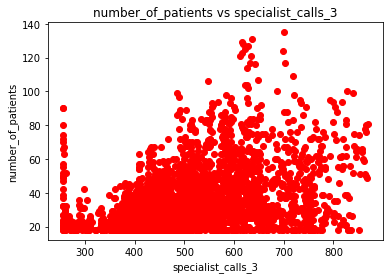

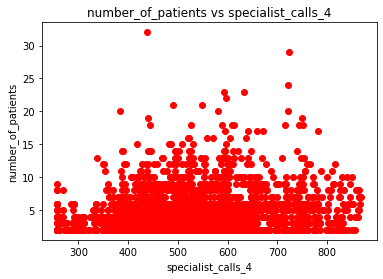

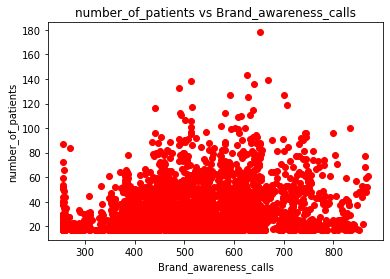

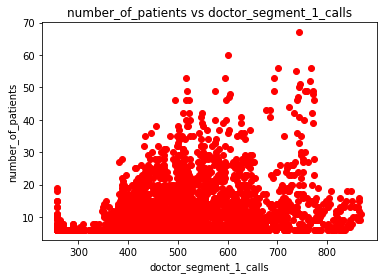

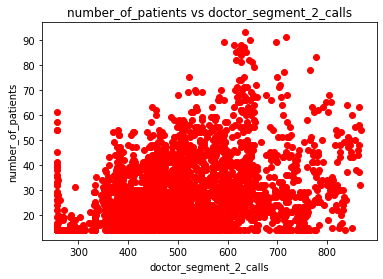

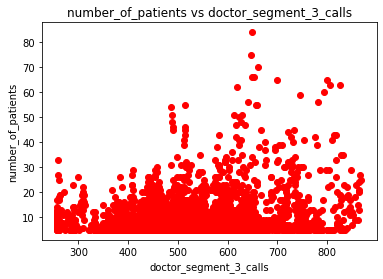

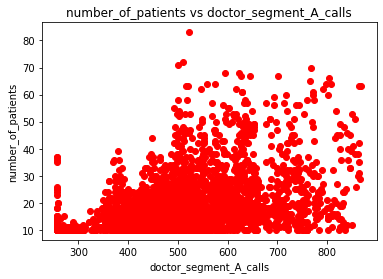

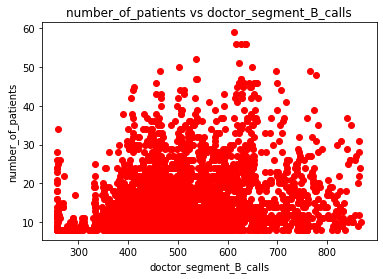

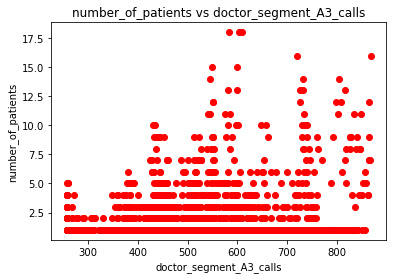

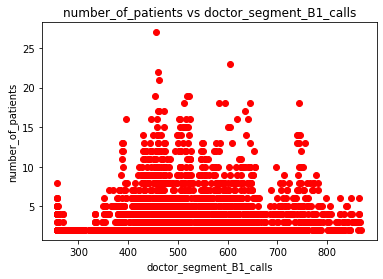

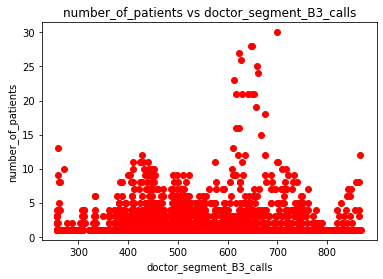

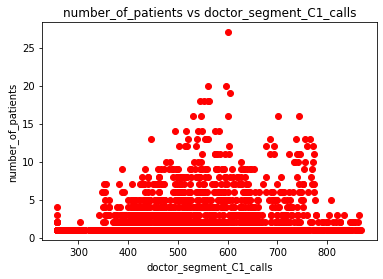

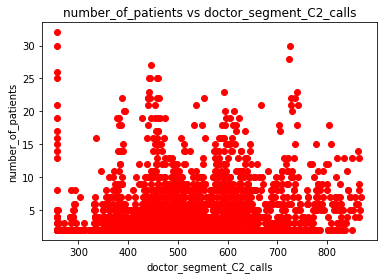

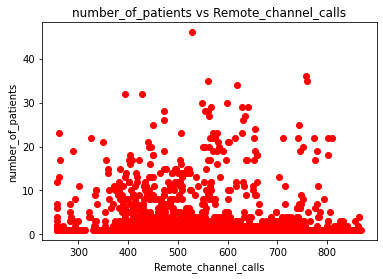

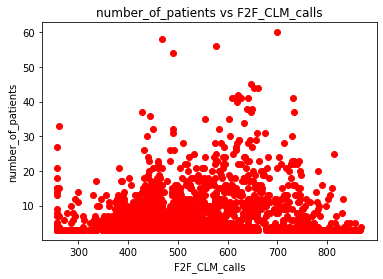

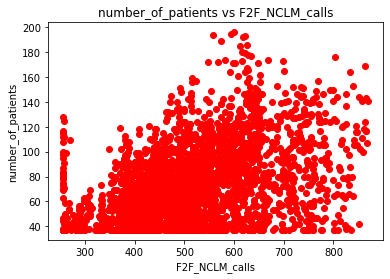

In [26]:
# Scatter graph b/w response and features
for x in features:
    plt.plot(labels, features[x], 'ro')  # arguments are passed to np.histogram
    plt.title("number_of_patients vs " + x)
    plt.xlabel(x)
    plt.ylabel("number_of_patients")
    plt.show()

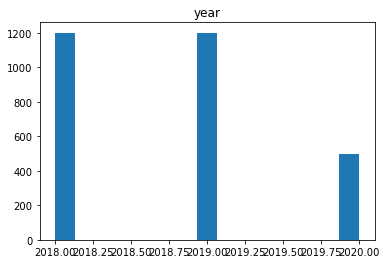

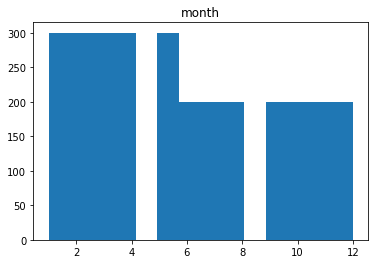

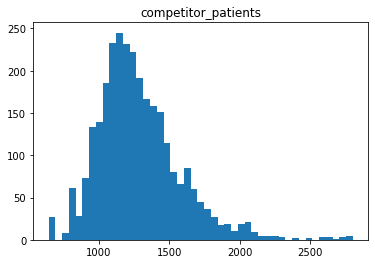

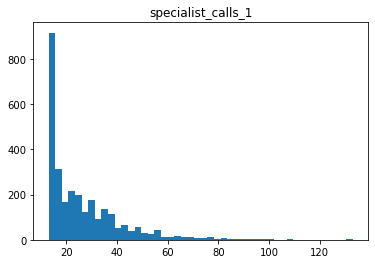

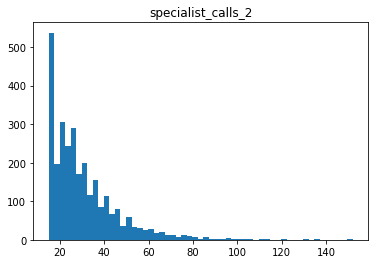

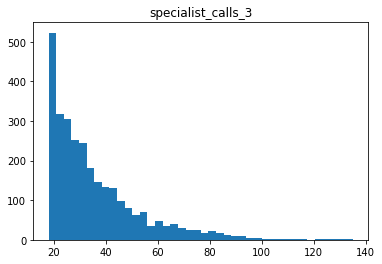

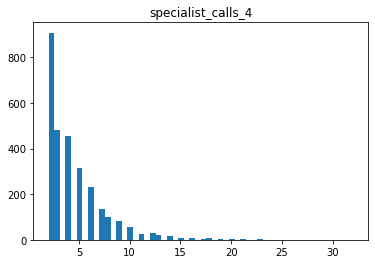

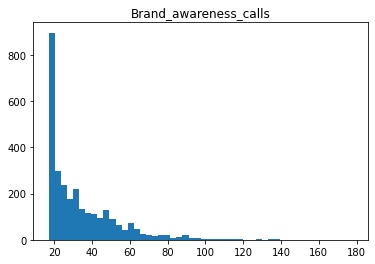

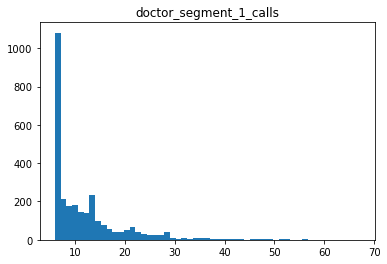

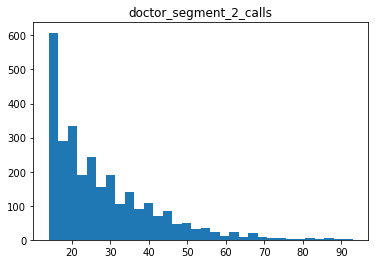

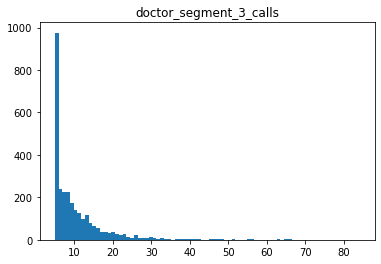

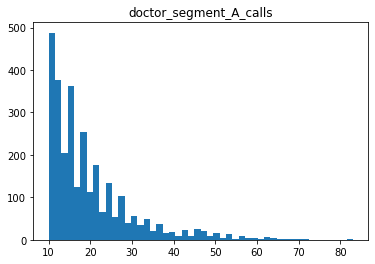

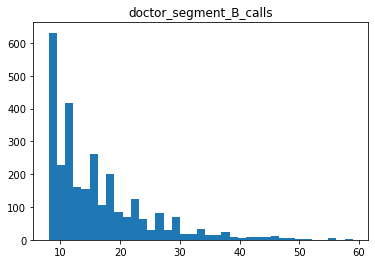

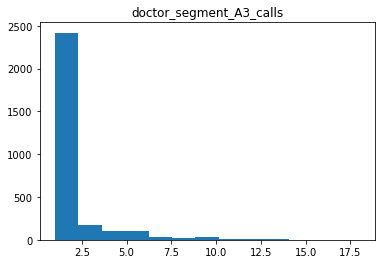

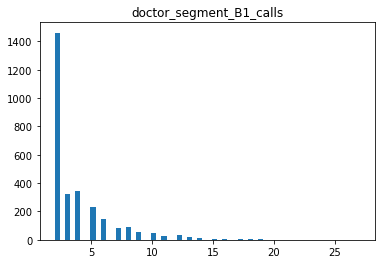

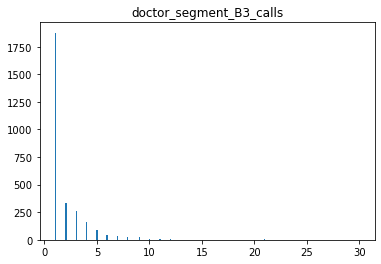

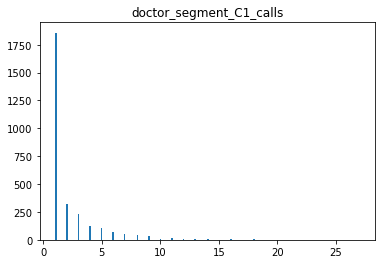

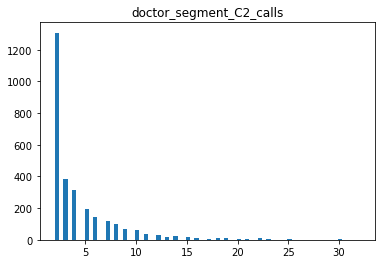

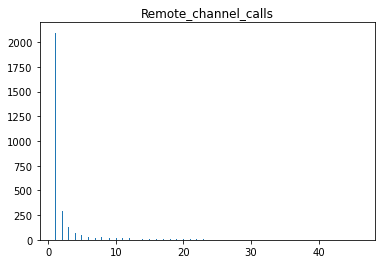

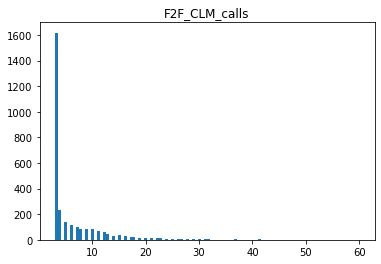

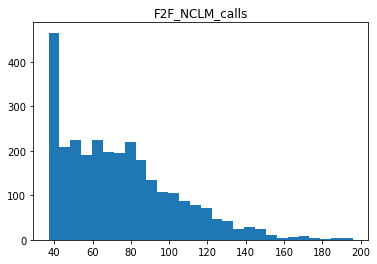

In [27]:
#Data Distribultion 
for x in features:
    plt.hist(features[x], bins='auto')  # arguments are passed to np.histogram
    plt.title(x)
    plt.show()

#### Based on histograms, the features are left skewed

### 3. Modeling with Less Preprocessing (Skewed data)

#### Optimum number of features

In [28]:
#no of features
nof_list=np.arange(1,22)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f percent" % (nof, high_score*100) )

Optimum number of features: 21
Score with 21 features: 43.317109 percent


#### Random Forest Regressor

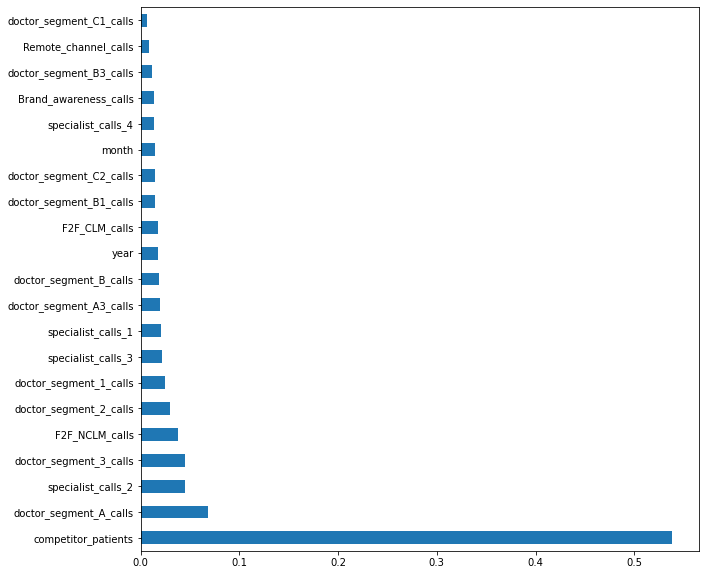

In [29]:
# Building Random Forest model

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=0)
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
# Visualizing Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

In [30]:
print("root mean square error of the random forest model is", np.sqrt(mean_squared_error(pred, y_test)))

root mean square error of the random forest model is 65.0888907015523


In [31]:
print("Score of the model with RandomForest Regressor is:" ,model.score(X_test, y_test)*100, "percent")

Score of the model with RandomForest Regressor is: 71.35221831185517 percent


In [32]:
print("root mean absolute error of the random forest model is", mean_absolute_error(pred, y_test))

root mean absolute error of the random forest model is 43.41379310344828


In [33]:
print("r2_score error of the random forest model is", r2_score(pred, y_test))

r2_score error of the random forest model is 0.5726543422216712


#### XGBOOST Regressor

In [34]:
#there was no hyper-parameter tuning such as grid search here, these parameters were given these values from experience, but one could do some hyper-parameter tuning to check if there will be improvement
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.01,
                 max_depth=15,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [35]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=15,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0.75,
             reg_lambda=0.45, scale_pos_weight=1, seed=42, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
pred = model.predict(X_test)

In [37]:
print("root mean square error of the xgboost regressor model is", np.sqrt(mean_squared_error(pred, y_test)))

root mean square error of the xgboost regressor model is 67.78773121987345


In [38]:
print("Score of the model withxgboost Regressor is:" ,model.score(X_test, y_test)*100, "percent")

Score of the model withxgboost Regressor is: 68.9272668015561 percent


In [39]:
print("root mean absolute error of the xgboost regressor model is", mean_absolute_error(pred, y_test))

root mean absolute error of the xgboost regressor model is 47.9812796757139


In [40]:
print("r2_score error of the xgboost regressor model is", r2_score(pred, y_test))

r2_score error of the xgboost regressor model is 0.41893387644216706


#### OLS for Multiple Linear Regression

In [10]:
data.columns

Index(['year', 'month', 'number_of_patients', 'competitor_patients',
       'specialist_calls_1', 'specialist_calls_2', 'specialist_calls_3',
       'specialist_calls_4', 'Brand_awareness_calls', 'doctor_segment_1_calls',
       'doctor_segment_2_calls', 'doctor_segment_3_calls',
       'doctor_segment_A_calls', 'doctor_segment_B_calls',
       'doctor_segment_A3_calls', 'doctor_segment_B1_calls',
       'doctor_segment_B3_calls', 'doctor_segment_C1_calls',
       'doctor_segment_C2_calls', 'Remote_channel_calls', 'F2F_CLM_calls',
       'F2F_NCLM_calls', 'month_year'],
      dtype='object')

In [11]:
#building an OLS model for Multiple-Linear Regression
#the Ordinary Least Square Regression model was built using features that were selected using the correlation analysis. Some features are not used since they were highly correlated with some other features.
''' 'doctor_segment_C_calls', 'doctor_segment_A1_calls', 'doctor_segment_A2_calls', 'doctor_segment_B2_calls', 'doctor_segment_C3_calls'
 have a correlation of greater than 0.8 with other features 
 so were not among the features used for building the OLS model to avoid the issue of multi-collinearity '''


model = sm.ols(formula="number_of_patients~competitor_patients+F2F_NCLM_calls+doctor_segment_A_calls+specialist_calls_1+month+year+specialist_calls_2+specialist_calls_3+specialist_calls_4+Brand_awareness_calls+doctor_segment_1_calls+doctor_segment_2_calls+doctor_segment_3_calls+doctor_segment_B_calls+doctor_segment_A3_calls+doctor_segment_B1_calls+doctor_segment_B3_calls+doctor_segment_C1_calls+doctor_segment_C2_calls+Remote_channel_calls+F2F_CLM_calls", data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     number_of_patients   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     105.8
Date:                Mon, 08 Jun 2020   Prob (F-statistic):               0.00
Time:                        07:37:29   Log-Likelihood:                -17246.
No. Observations:                2900   AIC:                         3.453e+04
Df Residuals:                    2879   BIC:                         3.466e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [12]:
#Actual and predicted values
labels=data['number_of_patients']
y_pred = model.predict()
df1 = pd.DataFrame({'Actual': labels, 'Predicted': y_pred})  
df1.head(10)

,Actual,Predicted
0,739,556.929849
1,508,538.485169
2,678,666.490467
3,404,378.023934
4,533,498.679118
5,422,406.251639
6,479,476.826235
7,483,497.866679
8,371,448.597263
9,830,595.845557


In [13]:
print("mean absolute error of the multi-linear regression model is", mean_absolute_error(y_pred, labels))

mean absolute error of the multi-linear regression model is 64.74169618862906


In [14]:
# Revising inputs based on P-values (Discarding specialist_calls_1, specialist_calls_3, doctor_segment_3_calls, doctor_segment_B1_calls)

model2 = sm.ols(formula="number_of_patients~competitor_patients+F2F_NCLM_calls+doctor_segment_A_calls+month+year+specialist_calls_2+specialist_calls_4+Brand_awareness_calls+doctor_segment_1_calls+doctor_segment_2_calls+doctor_segment_B_calls+doctor_segment_A3_calls+doctor_segment_B3_calls+doctor_segment_C1_calls+doctor_segment_C2_calls+Remote_channel_calls+F2F_CLM_calls", data=data).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:     number_of_patients   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     131.9
Date:                Mon, 08 Jun 2020   Prob (F-statistic):               0.00
Time:                        07:38:37   Log-Likelihood:                -17248.
No. Observations:                2900   AIC:                         3.453e+04
Df Residuals:                    2883   BIC:                         3.463e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2

In [15]:
#Actual and predicted values
labels=data['number_of_patients']
y_pred = model2.predict()
df1 = pd.DataFrame({'Actual': labels, 'Predicted': y_pred})  
df1.head(10)

,Actual,Predicted
0,739,561.303543
1,508,538.057448
2,678,663.194505
3,404,378.282443
4,533,498.978329
5,422,406.244461
6,479,477.674592
7,483,502.603765
8,371,451.889936
9,830,598.366061


In [16]:
print("mean absolute error of the multi-linear regression model is", mean_absolute_error(y_pred, labels))

mean absolute error of the multi-linear regression model is 64.78274570455552


### Feature Importance (Before Normalizing Distribution)
#### in RF: (orderly; most important comes first)
competitor_patients,
doctor_segment_A_calls,
specialist_calls_2,
doctor_segment_3_calls,
F2F_NCLM_calls,
doctor_segment_2_calls,
doctor_segment_1_calls,
specialist_calls_3,
specialist_calls_1,
doctor_segment_A3_call,
doctor_segment_B_calls,
year,
F2F_CLM_calls,
doctor_segment_B1_calls,
doctor_segment_C2_calls,
month,
specialist_calls_4,
Brand_awareness_calls,
doctor_segment_B3_calls,
Remote_channel_calls,
doctor_segment_C1_calls


#### in OLS without consideration of P-Values (orderly)

doctor_segment_C2_calls,
doctor_segment_C1_calls,
doctor_segment_B_calls,
doctor_segment_1_calls,
doctor_segment_2_calls,
doctor_segment_A_calls,
doctor_segment_A3_call,
doctor_segment_B3_calls,
year,
specialist_calls_4,
F2F_CLM_calls,
Remote_channel_calls,
month,
F2F_NCLM_calls,
doctor_segment_B1_calls,
Brand_awareness_calls,
doctor_segment_3_calls,
specialist_calls_2,
specialist_calls_1,
competitor_patients,
specialist_calls_3


#### in OLS with consideration of P-Values (orderly)
##### Discarding specialist_calls_2, doctor_segment_1_calls, doctor_segment_B_calls, doctor_segment_B1_calls, doctor_segment_B3_calls, doctor_segment_C1_calls, doctor_segment_C2_calls

doctor_segment_C2_calls,
doctor_segment_B_calls,
doctor_segment_C1_calls,
doctor_segment_1_calls,
doctor_segment_2_calls,
doctor_segment_A_calls,
doctor_segment_A3_call,
doctor_segment_B3_calls,
year,
specialist_calls_4,
F2F_CLM_calls,
Remote_channel_calls,
month,
F2F_NCLM_calls,
Brand_awareness_calls,
specialist_calls_2,
competitor_patients


#### Neural Networks

In [50]:
### Neural Network Model

train_stats = X_train.describe().transpose()

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(X_train)
normed_test_data = norm(X_test)

In [51]:
normed_train_data

,year,month,competitor_patients,specialist_calls_1,specialist_calls_2,specialist_calls_3,specialist_calls_4,Brand_awareness_calls,doctor_segment_1_calls,doctor_segment_2_calls,...,doctor_segment_A_calls,doctor_segment_B_calls,doctor_segment_A3_calls,doctor_segment_B1_calls,doctor_segment_B3_calls,doctor_segment_C1_calls,doctor_segment_C2_calls,Remote_channel_calls,F2F_CLM_calls,F2F_NCLM_calls
month_year,,,,,,,,,,,,,,,,,,,,,
2020-01,1.717401,-1.412878,1.082611,-0.842456,-0.992411,0.422651,0.476276,-0.560562,-0.760047,-1.022829,...,-0.946033,-0.984362,-0.400497,-0.647512,-0.44171,-0.506231,-0.636060,-0.349562,-0.525644,-0.103245
2020-01,1.717401,-1.412878,0.014104,-0.653578,-0.672785,-0.976986,-0.810674,-0.877340,-0.760047,-0.874384,...,-0.946033,-0.741911,-0.400497,-0.647512,-0.44171,-0.506231,-0.636060,-0.349562,-0.525644,-1.041124
2020-02,1.717401,-1.124021,-0.002696,-0.086943,-0.417084,1.094476,-0.810674,1.287309,-0.760047,0.535849,...,-0.946033,-0.499460,-0.400497,-0.647512,-0.44171,-0.506231,3.803327,-0.349562,5.042386,-0.840150
2018-01,-1.049523,-1.412878,-0.849437,-0.338781,-0.800636,-0.753044,0.154538,0.020198,-0.760047,-0.577492,...,-0.660672,-0.620685,-0.400497,-0.647512,-0.44171,-0.506231,-0.636060,-0.349562,1.112012,-0.739663
2018-06,-1.049523,0.031405,1.489181,1.046327,2.203855,0.366665,0.476276,0.284179,-0.138277,0.461627,...,1.051495,-0.135783,4.376395,1.081010,0.35479,-0.506231,1.453063,-0.349562,-0.361879,1.973485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08,-1.049523,0.609118,0.326592,-0.338781,-0.544934,-0.753044,-0.810674,-0.560562,-0.262631,-0.800161,...,-0.946033,-0.257008,-0.400497,0.389601,-0.04346,-0.102785,-0.374919,-0.349562,-0.525644,-0.639176
2018-09,-1.049523,0.897975,-2.159870,1.046327,-0.608860,0.646592,-0.810674,-0.666154,-0.262631,-0.429047,...,-0.565552,0.227894,1.191801,0.389601,-0.44171,-0.102785,-0.636060,-0.107043,1.439543,-0.371211
2019-05,0.333939,-0.257451,2.729052,-0.212862,0.669647,1.598345,-0.810674,0.548161,0.110430,2.020305,...,2.953903,-0.499460,-0.400497,-0.301808,-0.44171,-0.102785,-0.113779,-0.349562,-0.198113,1.236581


In [52]:
def build_model():
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [53]:
model = build_model()

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [50]:
EPOCHS = 1150

history = model.fit(
  normed_train_data, y_train,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:280454.2500,  mae:515.2002,  mse:280454.2500,  val_loss:262109.1562,  val_mae:498.6686,  val_mse:262109.1562,  
....................................................................................................
Epoch: 100, loss:8296.2314,  mae:63.9990,  mse:8296.2314,  val_loss:6481.9814,  val_mae:57.5952,  val_mse:6481.9814,  
....................................................................................................
Epoch: 200, loss:7525.8496,  mae:60.5960,  mse:7525.8496,  val_loss:6158.2134,  val_mae:56.1485,  val_mse:6158.2134,  
....................................................................................................
Epoch: 300, loss:6197.2017,  mae:56.0028,  mse:6197.2017,  val_loss:5972.2793,  val_mae:53.2931,  val_mse:5972.2793,  
....................................................................................................
Epoch: 400, loss:5389.0820,  mae:52.9558,  mse:5389.0820,  val_loss:5858.9165,  val_mae:53.2296,  val_mse:5858.

In [51]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
1145,3905.870605,44.732224,3905.870605,5663.336914,52.867527,5663.336914,1145
1146,3907.506348,44.796661,3907.506348,5615.224121,53.244370,5615.224121,1146
1147,3908.142822,44.814854,3908.142822,5593.317383,52.728951,5593.317383,1147
1148,3896.407959,44.682220,3896.407959,5575.541992,52.704987,5575.541992,1148
1149,3898.924805,44.615993,3898.924805,5721.031738,52.784039,5721.031738,1149


In [53]:
loss, mae, mse = model.evaluate(normed_test_data, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} No of Patients".format(mae))

14/14 - 0s - loss: 5844.9219 - mae: 54.0810 - mse: 5844.9219
Testing set Mean Abs Error: 54.08 No of Patients


In [54]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, y_train, 
                    epochs=EPOCHS, validation_split = 0.05, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:276942.0000,  mae:512.1376,  mse:276942.0000,  val_loss:259727.8125,  val_mae:494.8457,  val_mse:259727.8125,  
....................................................................................................
Epoch: 100, loss:7866.1206,  mae:62.2033,  mse:7866.1206,  val_loss:6933.0576,  val_mae:59.3209,  val_mse:6933.0576,  
...

In [55]:
loss, mae, mse = model.evaluate(normed_test_data, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} No of Patients".format(mae))

14/14 - 0s - loss: 8103.8838 - mae: 64.0960 - mse: 8103.8838
Testing set Mean Abs Error: 64.10 No of Patients


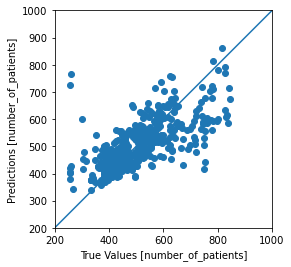

In [56]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [number_of_patients]')
plt.ylabel('Predictions [number_of_patients]')
lims = [200, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

### 4. Modeling with more Preprocessing (Normalizing distribution)

In [55]:
## the features are left skewed
## Normalizing distribution
for x in X.columns:
    X[x], _ = stats.boxcox(X[x])

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:910: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [56]:
#no of features
nof_list=np.arange(1,22)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f percent" % (nof, high_score*100) )

Optimum number of features: 21
Score with 21 features: 45.382716 percent


#### Random Forest Regressor

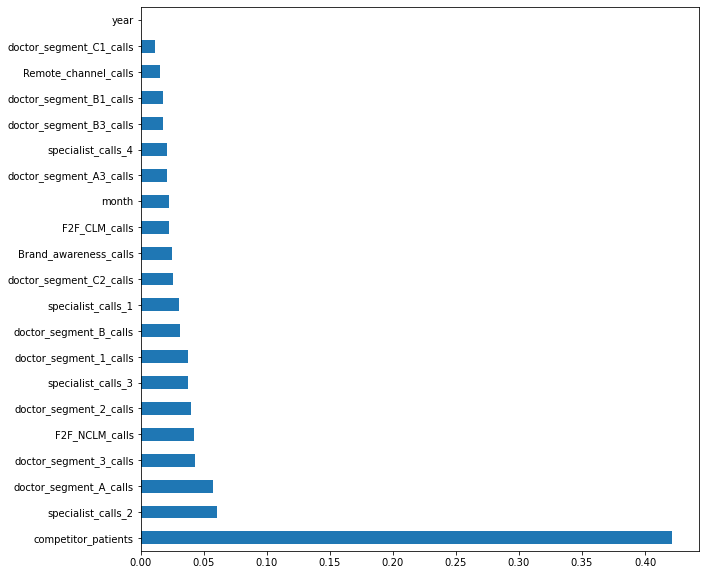

In [57]:
# Building Random Forest model
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=0)
model = RandomForestRegressor(n_estimators=1000, criterion='mae', max_depth=100)
model.fit(X_train, y_train)
pred = model.predict(X_test)
# Visualizing Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

In [58]:
print("root mean square error of the random forest model is", np.sqrt(mean_squared_error(pred, y_test)))

root mean square error of the random forest model is 65.27452171289002


In [59]:
print("Score of the model with RandomForest Regressor is:" ,model.score(X_test, y_test)*100, "percent")

Score of the model with RandomForest Regressor is: 71.18858055810581 percent


In [60]:
print("root mean absolute error of the random forest model is", mean_absolute_error(pred, y_test))

root mean absolute error of the random forest model is 44.88763103448276


In [61]:
print("r2_score error of the randomForest model is", r2_score(pred, y_test))

r2_score error of the randomForest model is 0.540547193936187


#### XGBOOST Regressor

In [62]:
#xgboost regressor
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.01,
                 max_depth=15,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [63]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [64]:
print("root mean square error is", np.sqrt(mean_squared_error(pred, y_test)))

root mean square error is 69.13625413764414


In [65]:
print("Score of the model with Xgboost Regressor is:" ,model.score(X_test, y_test)*100, "percent")

Score of the model with Xgboost Regressor is: 67.67869040284992 percent


In [66]:
print("root mean absolute error of the Xgboost model is", mean_absolute_error(pred, y_test))

root mean absolute error of the Xgboost model is 49.01791739628233


In [67]:
print("r2_score error of the Xgboost model is", r2_score(pred, y_test))

r2_score error of the Xgboost model is 0.38274546759046135


#### Neural Network

In [68]:
### Neural Network Model

train_stats = X_train.describe().transpose()

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(X_train)
normed_test_data = norm(X_test)

In [69]:
normed_train_data

,year,month,competitor_patients,specialist_calls_1,specialist_calls_2,specialist_calls_3,specialist_calls_4,Brand_awareness_calls,doctor_segment_1_calls,doctor_segment_2_calls,...,doctor_segment_A_calls,doctor_segment_B_calls,doctor_segment_A3_calls,doctor_segment_B1_calls,doctor_segment_B3_calls,doctor_segment_C1_calls,doctor_segment_C2_calls,Remote_channel_calls,F2F_CLM_calls,F2F_NCLM_calls
month_year,,,,,,,,,,,,,,,,,,,,,
2020-01,0.999797,-1.707077,1.119250,-1.295437,-1.573439,0.788139,0.895577,-0.430883,-1.204603,-1.504224,...,-1.594968,-1.493561,-0.571764,-0.927767,-0.722740,-0.736953,-0.996166,-0.611279,-0.827049,0.114784
2020-01,0.999797,-1.707077,0.152935,-0.687726,-0.699094,-1.529033,-1.241910,-1.332313,-1.204603,-1.084762,...,-1.594968,-0.810923,-0.571764,-0.927767,-0.722740,-0.736953,-0.996166,-0.611279,-0.827049,-1.203243
2020-02,0.999797,-1.169459,0.135459,0.350968,-0.212550,1.231442,-1.241910,1.336540,-1.204603,0.834295,...,-1.594968,-0.317042,-0.571764,-0.927767,-0.722740,-0.736953,1.814190,-0.611279,1.769474,-0.851369
2018-01,0.999797,-1.707077,-0.872532,-0.016134,-1.003357,-0.868560,0.619207,0.467737,-1.204603,-0.449916,...,-0.712623,-0.546024,-0.571764,-0.927767,-0.722740,-0.736953,-0.996166,-0.611279,1.524539,-0.693316
2018-06,0.999797,0.186935,1.426802,1.240982,1.732683,0.741772,0.895577,0.725355,0.340880,0.777158,...,1.248278,0.218461,1.898992,1.368442,1.362600,-0.736953,1.492564,-0.611279,0.087191,1.644538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08,0.999797,0.686674,0.463548,-0.016134,-0.438660,-0.868560,-1.241910,-0.430883,0.146456,-0.904394,...,-1.594968,0.060464,-0.571764,1.031793,0.965235,0.878947,0.012166,-0.611279,-0.827049,-0.545279
2018-09,0.999797,0.913401,-3.245303,1.240982,-0.564068,0.956901,-1.241910,-0.680882,0.146456,-0.201935,...,-0.492602,0.605891,1.848942,1.031793,-0.722740,0.878947,-0.996166,1.262727,1.583548,-0.191428
2019-05,0.999797,-0.093848,2.222067,0.181077,0.963954,1.469934,-1.241910,0.930833,0.646546,1.615417,...,1.921552,-0.317042,-0.571764,0.193267,-0.722740,0.878947,0.528503,-0.611279,0.574060,1.216949


In [70]:
def build_model():
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [71]:
model = build_model()

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                352       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [35]:
EPOCHS = 1500

history = model.fit(
  normed_train_data, y_train,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:280119.8750,  mae:514.9395,  mse:280119.8750,  val_loss:261539.7500,  val_mae:498.1987,  val_mse:261539.7500,  
....................................................................................................
Epoch: 100, loss:7345.6265,  mae:61.5981,  mse:7345.6265,  val_loss:6682.1646,  val_mae:57.1911,  val_mse:6682.1646,  
....................................................................................................
Epoch: 200, loss:6390.4639,  mae:57.4289,  mse:6390.4639,  val_loss:6656.3813,  val_mae:58.8880,  val_mse:6656.3813,  
....................................................................................................
Epoch: 300, loss:5983.3530,  mae:55.8261,  mse:5983.3530,  val_loss:6316.7930,  val_mae:57.7101,  val_mse:6316.7930,  
....................................................................................................
Epoch: 400, loss:5614.1621,  mae:54.1162,  mse:5614.1621,  val_loss:6237.8130,  val_mae:58.1102,  val_mse:6237.

In [36]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
1495,3442.615723,42.381916,3442.615723,5688.183594,53.050232,5688.183594,1495
1496,3443.027588,42.423130,3443.027588,5640.074219,53.270397,5640.074219,1496
1497,3439.422852,42.282757,3439.422852,5702.249512,53.820316,5702.249512,1497
1498,3435.131836,42.395767,3435.131836,5759.770020,54.798939,5759.770020,1498
1499,3440.463135,42.332233,3440.463135,5753.167480,53.635754,5753.167480,1499


In [37]:
loss, mae, mse = model.evaluate(normed_test_data, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} No of Patients".format(mae))

14/14 - 0s - loss: 6091.0034 - mae: 57.9009 - mse: 6091.0034
Testing set Mean Abs Error: 57.90 No of Patients


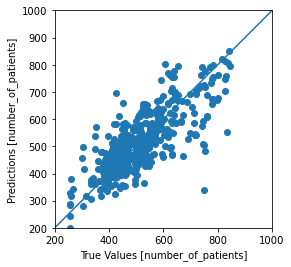

In [38]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [number_of_patients]')
plt.ylabel('Predictions [number_of_patients]')
lims = [200, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

#### OLS for Multiple-Linear Regression

In [73]:
data.columns

Index(['year', 'month', 'number_of_patients', 'competitor_patients',
       'specialist_calls_1', 'specialist_calls_2', 'specialist_calls_3',
       'specialist_calls_4', 'Brand_awareness_calls', 'doctor_segment_1_calls',
       'doctor_segment_2_calls', 'doctor_segment_3_calls',
       'doctor_segment_A_calls', 'doctor_segment_B_calls',
       'doctor_segment_A3_calls', 'doctor_segment_B1_calls',
       'doctor_segment_B3_calls', 'doctor_segment_C1_calls',
       'doctor_segment_C2_calls', 'Remote_channel_calls', 'F2F_CLM_calls',
       'F2F_NCLM_calls'],
      dtype='object')

In [74]:
data1=data

for x in data1.columns:
    data1[x], _ = stats.boxcox(data1[x])

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:910: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [75]:
#building an OLS model for Multiple-Linear Regression
#the Ordinary Least Square Regression model was built using features that were selected using the correlation analysis. Some features are not used since they were highly correlated with some other features.
''' 'doctor_segment_C_calls', 'doctor_segment_A1_calls', 'doctor_segment_A2_calls', 'doctor_segment_B2_calls', 'doctor_segment_C3_calls'
 have a correlation of greater than 0.8 with other features 
 so were not among the features used for building the OLS model to avoid the issue of multi-collinearity '''


model = sm.ols(formula="number_of_patients~competitor_patients+F2F_NCLM_calls+doctor_segment_A_calls+specialist_calls_1+month+year+specialist_calls_2+specialist_calls_3+specialist_calls_4+Brand_awareness_calls+doctor_segment_1_calls+doctor_segment_2_calls+doctor_segment_3_calls+doctor_segment_B_calls+doctor_segment_A3_calls+doctor_segment_B1_calls+doctor_segment_B3_calls+doctor_segment_C1_calls+doctor_segment_C2_calls+Remote_channel_calls+F2F_CLM_calls", data=data1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     number_of_patients   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     122.8
Date:                Mon, 08 Jun 2020   Prob (F-statistic):               0.00
Time:                        06:46:12   Log-Likelihood:                -3662.1
No. Observations:                2900   AIC:                             7366.
Df Residuals:                    2879   BIC:                             7492.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [77]:
# Revising inputs based on P-values (Discarding specialist_calls_2, doctor_segment_1_calls, doctor_segment_B_calls, doctor_segment_B1_calls, doctor_segment_B3_calls, doctor_segment_C1_calls, doctor_segment_C2_calls)

model1 = sm.ols(formula="number_of_patients~competitor_patients+F2F_NCLM_calls+doctor_segment_A_calls+specialist_calls_1+month+year+specialist_calls_3+specialist_calls_4+Brand_awareness_calls+doctor_segment_2_calls+doctor_segment_3_calls+doctor_segment_A3_calls+Remote_channel_calls+F2F_CLM_calls", data=data1).fit()
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:     number_of_patients   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     188.8
Date:                Mon, 08 Jun 2020   Prob (F-statistic):               0.00
Time:                        06:50:10   Log-Likelihood:                -3664.5
No. Observations:                2900   AIC:                             7357.
Df Residuals:                    2886   BIC:                             7441.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [78]:
#Actual and predicted values
labels=data['number_of_patients']
y_pred = model1.predict()
df1 = pd.DataFrame({'Actual': labels, 'Predicted': y_pred})  
df1.head(10)

,Actual,Predicted
month_year,,
2018-01,17.237807,15.930784
2018-01,15.306962,15.389273
2018-01,16.777511,16.506794
2018-01,14.214767,13.386073
2018-01,15.544235,14.934159
2018-01,14.417715,13.775917
2018-01,15.020572,14.664475
2018-01,15.060828,15.216412
2018-01,13.824499,14.476999


In [79]:
print("mean absolute error of the multi-linear regression model is", mean_absolute_error(y_pred, labels))

mean absolute error of the multi-linear regression model is 0.6096972852349735


### Feature Importance

#### in RF: (most important feature comes first)
competitor_patients,
specialist_calls_2,
doctor_segment_A_calls,

doctor_segment_3_calls,
F2F_NCLM_calls,
doctor_segment_2_calls,
specialist_calls_3,
doctor_segment_1_calls,
doctor_segment_B_calls,
specialist_calls_1,
doctor_segment_C2_calls,
Brand_awareness_calls,
F2F_CLM_calls,
month,
doctor_segment_A3_call,
specialist_calls_4,
doctor_segment_B3_calls,
doctor_segment_B1_calls,
Remote_channel_calls,
doctor_segment_C1_calls,
year



#### in OLS with consideration of P-Values (orderly)
##### Discarding specialist_calls_2, doctor_segment_1_calls, doctor_segment_B_calls, doctor_segment_B1_calls, doctor_segment_B3_calls, doctor_segment_C1_calls, doctor_segment_C2_calls



competitor_patients,
doctor_segment_A_calls,
Brand_awareness_calls,
doctor_segment_3_calls,
specialist_calls_3,
doctor_segment_2_calls,
specialist_calls_1,
F2F_CLM_calls,
F2F_NCLM_calls,
doctor_segment_A3_call,
Remote_channel_calls,
specialist_calls_4,
month,
year

### CONCLUSION

1. The Random Forest Regressor had superior performance comparing with the Neural Networks, XGBOOST and Multiple Linear Regression model.
2. Normalizing the entire feature improved the performance of the models. Such that, the best model is the Random Forest Model built on normalized features with a score of 71%, R_squared of 55%, and MAE of 44